In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

# What does human power output with time look like?

Import time to exhaustion data

In [2]:
import pandas as pd
from carpy.utility import GetPath, cast2quantity

# Read the data from the relevant file
excel_path = os.path.join(GetPath.library(), "propulsion\\data\\cycling_exhaustion_malewicki.xlsx")
dfs = pd.read_excel(excel_path, sheet_name=None)

data_healthy = cast2quantity(dfs["healthy"])
data_athlete = cast2quantity(dfs["athlete"])

Create power models

In [3]:
import numpy as np
from carpy.utility import Quantity
from scipy.optimize import curve_fit

def func(x, a, b, c):
    """Exponential model with controlling parameters a, b, and c."""
    return a * np.exp(-b * (x - c))

def cnuf(y, a, b, c):
    """Inverse of func."""
    return np.log(y / a) / -b + c

# Model parameters for a healthy human's sustained power output
p0 = (1, 1e-2, max(data_healthy["power"]).x)
popt_healthy, _ = curve_fit(func, data_healthy["power"], data_healthy["time"], p0=p0)

# Model parameters for an athlete's sustained power output
p0 = (1, 1e-2, max(data_athlete["power"]).x)
popt_athlete, _ = curve_fit(func, data_athlete["power"], data_athlete["time"], p0=p0)

Visualise the chart to make sure our models make sense

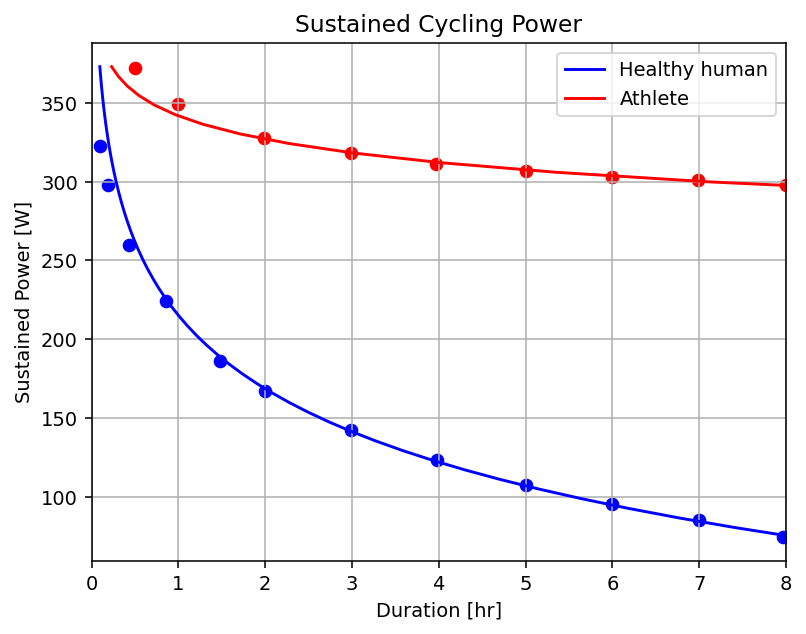

In [4]:
power = Quantity(np.linspace(0.1, 0.5), "hp")
time_healthy = Quantity(func(power.to("W"), *popt_healthy), "s")
time_athlete = Quantity(func(power.to("W"), *popt_athlete), "s")

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, dpi=140)

# Plot raw data
ax.scatter(data_healthy["time"].to("hr"), data_healthy["power"], c="blue")
ax.scatter(data_athlete["time"].to("hr"), data_athlete["power"], c="red")

# Plot models
ax.plot(time_healthy.to("hr"), power, c="blue", label="Healthy human")
ax.plot(time_athlete.to("hr"), power, c="red", label="Athlete")

ax.set_xlim(0, 8)
ax.set_title("Sustained Cycling Power")
ax.set_xlabel("Duration [hr]")
ax.set_ylabel("Sustained Power [W]")
ax.legend()
ax.grid()
plt.show()

The curve fits *mostly* work, but suffer in the < 1 hour sustained power regime.
The athletic performance of a healthy human is over predicted, and the performance of an athlete is underpredicted.

# Is Malewicki's performance model feasible?

Import [cyclist performance data](https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare) by demographic 

In [5]:
import pandas as pd

# Read the data from the relevant file
excel_path = os.path.join(GetPath.library(), "propulsion\\data\\cyclinganalytics_power.xlsx")
dfs = pd.read_excel(excel_path, sheet_name=None)

data_men = cast2quantity(dfs["M W"])
data_women = cast2quantity(dfs["F W"])

> "It’s worth saying a few words about Cycling Analytics users, because they aren’t a perfectly random sampling of cyclists or people overall. The best term that I can think of is that Cycling Analytics users are 'serious cyclists'. All the data here comes from people with power meters, and about half of Cycling Analytics users race regularly."

Plot the percentile of athlete you need to be, to sustain a cycling output of however many watts

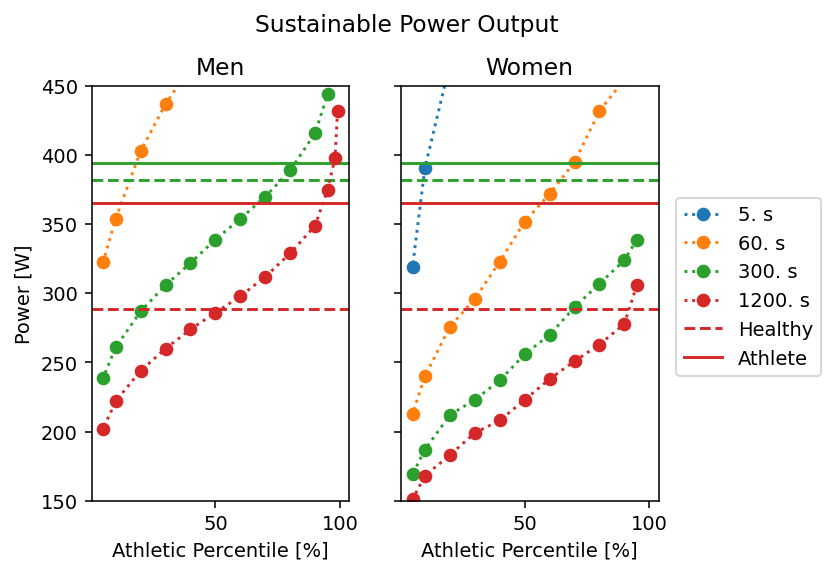

In [6]:
fig, axs = plt.subplots(1, 2, dpi=140, figsize=(6, 4), sharex=True, sharey=True)
fig.suptitle("Sustainable Power Output")
fig.subplots_adjust(top=0.85, right=0.8)

times = Quantity([5, 60, 300, 1200], "s")

for i, dataset in enumerate([data_men, data_women]):
    # Plot series data
    for time in times:
        series = f"{int(time.x)}s"
        line, = axs[i].plot(dataset["percentile [%]"], dataset[series], label=time, ls=":", marker="o")
    
        # The power Malewicki thinks a healthy human can produce for the given time
        power_h = Quantity(cnuf(time, *popt_healthy), "s")
        # The power Malewicki thinks an athletic human can produce for the given time
        power_a = Quantity(cnuf(time, *popt_athlete), "s")
        
        # It only makes sense for the athlete to outperform the healthy human
        if power_a >= power_h:
            line_h = axs[i].axhline(power_h, ls="--", c=line.get_color())
            line_a = axs[i].axhline(power_a, ls="-", c=line.get_color())
        
# Make plot pretty
for ax in axs.flat:
    ax.set_xlabel("Athletic Percentile [%]")
else:
    axs[0].set_title("Men")
    axs[1].set_title("Women")
    axs[0].set_ylabel("Power [W]")
    axs[0].set_ylim(150, 450)
    
    handles, labels = ax.get_legend_handles_labels()
    handles += [line_h, line_a]
    labels += ["Healthy", "Athlete"]
    fig.legend(handles=handles, labels=labels, loc="right")
    
plt.show()

Recall that Malewicki's models for healthy humans tend to over predict what a healthy human can sustain for shorter, sub 1 hour sprints, and under predict what athletes can sustain.

Results should be viewed with caution, as the available data for real (and serious) cyclist performance maxes out at 20 minutes, and this sub 1-hour time regime is where our curve fit model on Malewicki data really suffers.
You can see this in the proximity of healthy human and athletic human sustained wattage predictions for 300 seconds of output.

##### Malewicki's Healthy Humans

Taking the error in our curve fit model to be about a 30 Watt overprediction of Malewicki's model, it appears that men in the 30% performance percentile and higher can certainly produce about 260 Watts for 20 minutes.
For the same output, a woman exceeding the performance of at least 80% of their cohort is needed.

##### Malewicki's Athletes

Given that the performance of athletes is lower in our surrogate model than Malewicki's performance curve, it is likely that only the top ~4% of men will be able to sustain the power output suggested by Malewicki.
Since we're using cyclist data from "serious" cyclists, including a wider population of amateur cyclists would likely push this demographic up to something more akin to the sub-1 percent top performers of the world.

# What is the available sustained power for a channel crossing?

Work out the times that it would take to cross the channel at the shortest point, with no wind

In [7]:
channel_dist = Quantity(20.5, "mi")
crossing_speeds = Quantity(np.linspace(0, 15), "m s^{-1}")

crossing_times = channel_dist / crossing_speeds

Plot the crossing speed and the power available for a given crossing time

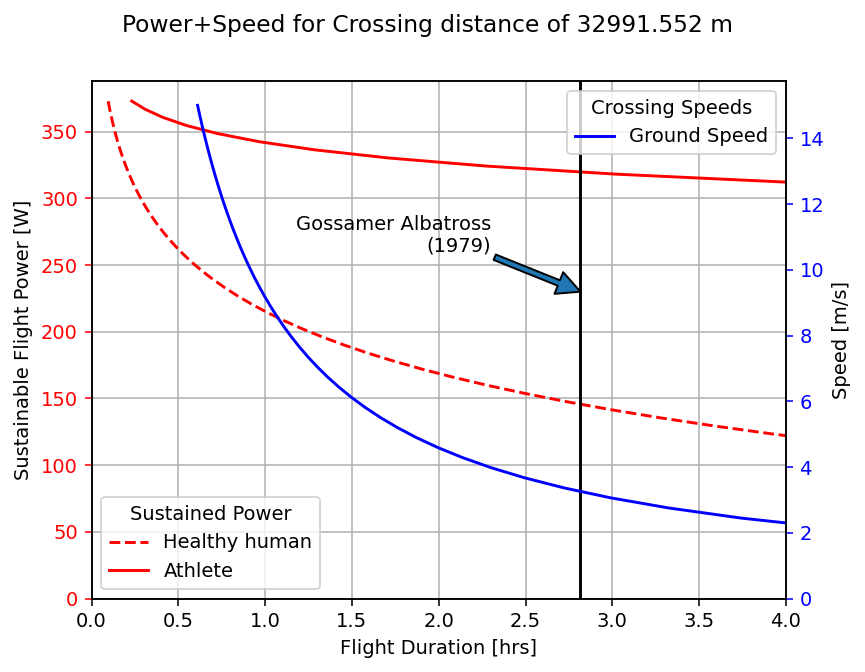

In [25]:
fig, ax = plt.subplots(1, dpi=140)
fig.suptitle(f"Power+Speed for Crossing distance of {channel_dist}")
ax2 = ax.twinx()

# Plot sustained power
line_p, = ax.plot(time_healthy.to("hr"), power.to("W"), c="red", ls="--", label="Healthy human")
ax.plot(time_athlete.to("hr"), power.to("W"), c="red", ls="-", label="Athlete")

# Plot crossing time
line_t, = ax2.plot(crossing_times.to("hr"), crossing_speeds, ls="-", c="blue", label="Ground Speed")

# Mark out the MacCready Gossamer Albatross' 1979 flight
albatross_t = Quantity(2, "hr") + Quantity(49, "min")
ax.axvline(albatross_t.to("hr"), c="black", ls="-")
ax.annotate(
    "Gossamer Albatross\n(1979)",
    xy=(albatross_t.to("hr"), 230), xytext=(2.3, 260),
    arrowprops={"width":3}, horizontalalignment="right"
)

# Make axis 1 pretty
ax.set_xlim(0, 4)
ax.set_ylim(0, None)
ax.set_xlabel("Flight Duration [hrs]")
ax.set_ylabel("Sustainable Flight Power [W]")
ax.tick_params(axis="y", colors=line_p.get_color())

# Make axis 2 pretty
ax2.set_ylim(0, None)
ax2.set_ylabel("Speed [m/s]")
ax2.tick_params(axis="y", colors=line_t.get_color())

ax.legend(title="Sustained Power", loc="lower left")
ax2.legend(title="Crossing Speeds", loc="upper right")
ax.grid()
plt.show()